## Fires Exploration With Sentinel-2

Notebook that implements simple fire hotspot detection from infrared bands on Sentinel-2. This notebook utilizes the Descartes Labs platform to access all imagery in a more Python-native way.

### Load in TPA points

In [1]:
import cv2
import descarteslabs as dl
import descarteslabs.workflows as wf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import geopandas as gpd
import os

/Users/ckruse/miniforge3/envs/m1-plastics/lib/python3.9/site-packages/descarteslabs/client/__init__.py:34: FutureWarning: Python version 3.9 is not supported yet. You may encounter unexpected errors.
  warnings.warn(msg, FutureWarning)
/Users/ckruse/miniforge3/envs/m1-plastics/lib/python3.9/site-packages/descarteslabs/common/workflows/arrow_serialization/context.py:57: FutureWarning: 'pyarrow.SerializationContext' is deprecated and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  serialization_context = pa.SerializationContext()
/Users/ckruse/miniforge3/envs/m1-plastics/lib/python3.9/site-packages/descarteslabs/common/workflows/arrow_serialization/context.py:58: FutureWarning: 'pyarrow.register_default_serialization_handlers' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  pa.register_default_serialization_handlers(serialization_context)


In [20]:
tpa_file = '../../data/sampling_locations/tpa_points.geojson'
tpa = gpd.read_file(tpa_file)
tpa

,id,From Kab,From_#KEC,ID,Kab,Kecamatan,Name,Surface_Ha,TOT_Kg/Day,geometry
0,00000000000000000004,NaN,NaN,5,Klungkung,Nusa Penida,TPA Jungut Batu,1.20,NaN,POINT (115.45941 -8.67096)
1,00000000000000000005,1.0,1.0,6,Klungkung,Nusa Penida,TPA Biaung,1.85,9433.0,POINT (115.49802 -8.67993)
2,00000000000000000003,1.0,3.0,4,Klungkung,Dawan,TPA Sente,1.00,43219.0,POINT (115.45446 -8.53037)
3,00000000000000000006,1.0,4.0,7,Bangli,Bangli,TPA Regional Bangli,0.99,47350.0,POINT (115.36793 -8.35354)
4,00000000000000000008,1.0,5.0,9,Jembrana,Negara,TPA Peh,2.00,38130.0,POINT (114.58329 -8.32794)
5,00000000000000000001,1.0,7.0,2,Gianyar,Temesi,TPA Temesi,1.05,209560.0,POINT (115.35024 -8.56212)
6,00000000000000000007,1.0,7.0,8,Buleleng,Kubutambahan,TPA Bengkala,0.35,125350.0,POINT (115.17015 -8.09141)
7,00000000000000000009,1.0,8.0,10,Karangasem,Karangasem,TPA Bebandem,0.77,43860.0,POINT (115.56421 -8.40345)
8,00000000000000000002,1.0,10.0,3,Tabanan,Kerambitan,TPA Mandung,2.50,64580.0,POINT (115.09513 -8.52995)
9,00000000000000000000,3.0,15.0,1,Denpasar,Denpasar Selatan,TPA Regional Suwung,4.52,1358533.0,POINT (115.22111 -8.72078)


### Define product parameters

In [6]:
# define products
s2_id = 'sentinel-2:L1C'
cloud_fraction = 0.3

# define bands -> same for both L8 and S2
bands = [
    'coastal-aerosol',
    'blue',
    'green',
    'red',
    'nir',
    'swir1',
    'swir2',
    'cloud-mask'
]

# resample all bands to 10 meter
resolution = 10
resampler = 'cubic'
scaling = 'physical'

# define tilesize parameters for each point
# 200x200 tiles
pad = 90
tilesize = 20

### Pull Imagery

In [7]:
def filter_cloud_mask(scenes, stack, cloud_fraction):
    '''
    filter a stack of imagery by its cloud mask and a specified cloud fraction
    
    this function assumes that:
    - the cloud fraction is computed on the entire image
    - the cloud mask is last band in each scene
    - the cloud mask is binary
    '''
    
    scenes_filt = list()
    stack_filt = list()
    for scene, img in zip(scenes, stack):
        cloud_mask = img[-1, :, :]
        
        cloudy_pixels = np.count_nonzero(cloud_mask)
        total_pixels = cloud_mask.shape[0] * cloud_mask.shape[1]
        
        cf = cloudy_pixels / total_pixels
        
        if cf < cloud_fraction:
            scenes_filt.append(scene)
            stack_filt.append(img)

    scenes_filt = dl.scenes.SceneCollection(scenes_filt)
    stack_filt = np.stack(stack_filt)
    
    return scenes_filt, stack_filt

In [8]:
imagery = dict()

tif_dir = '../data/fires/tifs_by_site'
if not os.path.exists(tif_dir):
    os.makedirs(tif_dir)

for ridx, row in tpa.iterrows():
    name = row['Name'].replace(' ', '_')
    lon, lat = row['geometry'].x, row['geometry'].y

    print('\n******************')
    print('Processing {}'.format(name))
    
    # build geocontext
    tile = dl.scenes.DLTile.from_latlon(lat, lon, resolution, tilesize, pad)
    
    # search for scenes
    s2_scenes, ctx = dl.scenes.search(products=s2_id,
                                      aoi=tile,
                                      cloud_fraction=cloud_fraction,
                                      limit=None)
    
    print('Found {} S2 scenes'.format(len(s2_scenes)))
    
    # rasterize scenes
    print('Rasterizing...')
    s2_stack = s2_scenes.stack(bands=bands, 
                               ctx=ctx,
                               scaling=scaling,
                               resampler=resampler)
    
    # filter by cloud masks
    s2_scenes, s2_stack = filter_cloud_mask(s2_scenes, s2_stack, cloud_fraction)
    
    print('With cloud masks, filtered to {} S2 scenes'.format(len(s2_scenes)))
    
    # write scenes to TIF
    outdir = os.path.join(tif_dir, name)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
        
    print('Downloading...')
    s2_scenes.download(bands=bands,
                       ctx=ctx,
                       scaling=scaling,
                       resampler=resampler,
                       dest=outdir, 
                       format='tif')
    
    # store off data in dictionary
    data = dict()
    data['s2'] = (s2_scenes, s2_stack)
    data['ctx'] = ctx # store off geocontext
    imagery[name] = data


******************
Processing TPA_Jungut_Batu
Found 206 S2 scenes
Rasterizing...
With cloud masks, filtered to 132 S2 scenes
Downloading...

******************
Processing TPA_Biaung
Found 206 S2 scenes
Rasterizing...
With cloud masks, filtered to 138 S2 scenes
Downloading...

******************
Processing TPA_Sente
Found 208 S2 scenes
Rasterizing...
With cloud masks, filtered to 156 S2 scenes
Downloading...

******************
Processing TPA_Regional_Bangli
Found 213 S2 scenes
Rasterizing...
With cloud masks, filtered to 118 S2 scenes
Downloading...

******************
Processing TPA_Peh
Found 349 S2 scenes
Rasterizing...
With cloud masks, filtered to 288 S2 scenes
Downloading...

******************
Processing TPA_Temesi
Found 208 S2 scenes
Rasterizing...
With cloud masks, filtered to 172 S2 scenes
Downloading...

******************
Processing TPA_Bengkala
Found 216 S2 scenes
Rasterizing...
With cloud masks, filtered to 202 S2 scenes
Downloading...

******************
Processing TPA_B

### Spot Check

In [9]:
def rescale_img(img, min_val=0.0, max_val=1.0, dtype=np.float32, pmin=0.0, pmax=100.0, vmin=None, vmax=None):
    """
    Return a scaled image between [0, 255] regardless of input scaling.

    Parameters
    ----------
    img: np.array
        Image as NumPy array
    min_val: float
        Minimum value of rescaled image (default 0.0)
    max_val: float
        Maximum value of rescaled image (default 1.0)
    dtype : np.dtype
        Type to return rescaled image (default np.float32)
    pmin : float
        Minimum percentage of values for scaling (default 0%)
    pmax : float
        Maximum percentage of values for scaling (default 100%)

    Returns
    -------
    img_rescale: np.array
        Image as NumPy array

    """

    # compute min and max percentile ranges to scale with
    if vmin is None or vmax is None:
        vmin, vmax = np.nanpercentile(img, pmin), np.nanpercentile(img, pmax)
        
    # rescale & clip
    img_rescale = ((img - vmin) * (1.0 / (vmax - vmin) * max_val)).astype(dtype)
    np.clip(img_rescale, min_val, max_val, out=img_rescale)

    return img_rescale

(-0.5, 199.5, 199.5, -0.5)

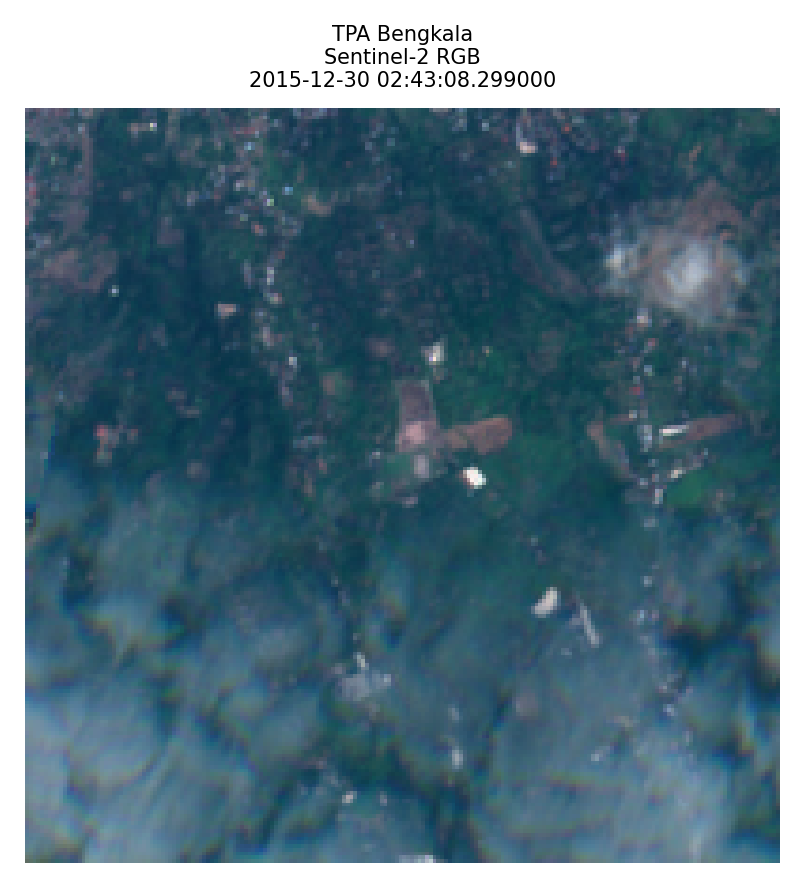

In [10]:
# look at Bengkala
tpa_name = 'TPA_Bengkala'
tpa_site = imagery[tpa_name]

s2_scenes, s2_stack = tpa_site['s2']

scene_idx = 0
s2_scene = s2_scenes[scene_idx]
s2_img = s2_stack[scene_idx, :, :, :]

s2_rgb = np.stack([s2_img[3, :, :], s2_img[2, :, :], s2_img[1, :, :]], axis=0)
s2_rgb = np.transpose(s2_rgb, axes=(1, 2, 0)) # bands last
s2_rgb = rescale_img(s2_rgb, vmin=0.05, vmax=0.25) # scale the data for viz

fig, ax = plt.subplots(nrows=1, ncols=1, dpi=250)
ax.set_title('{}\nSentinel-2 RGB\n{}'.format(tpa_name.replace('_', ' '), s2_scene.properties.date), fontsize=6)
ax.imshow(s2_rgb)
ax.axis('off')

### Find fires in stacks of imagery

In [12]:
def plot_scene(name, scene, img, fires, plot_dir):
    '''
    plot a single scene with RGB and IR fire views
    '''
    
    fig, ax = plt.subplots(nrows=1, ncols=3, dpi=300)
    
    rgb_img = np.stack([img[3, :, :], img[2, :, :], img[1, :, :]], axis=0)
    rgb_img = np.transpose(rgb_img, axes=(1, 2, 0))
    rgb_img = rescale_img(rgb_img, vmin=0.05, vmax=0.25) # custom scaling for viz

    
    ir_img = np.stack([img[6, :, :], img[5, :, :], img[4, :, :]], axis=0)
    ir_img = np.transpose(ir_img, axes=(1, 2, 0))
    ir_img = rescale_img(ir_img, vmin=0.08, vmax=0.9) # custom scaling for viz
    
    name_str = name.replace('_', ' ')
    date_str = scene.properties.date.strftime('%Y-%m-%d')
    ax[0].set_title('{}\nTrue Color\n{}'.format(name_str, date_str), fontsize=5)
    ax[0].imshow(rgb_img)
    ax[0].axis('off')
    
    ax[1].set_title('{}\nInfrared\n{}'.format(name_str, date_str), fontsize=5)
    ax[1].imshow(ir_img)
    ax[1].axis('off')
    
    ax[2].set_title('{}\nFires\n{}'.format(name_str, date_str), fontsize=5)
    ax[2].imshow(fires.astype(np.uint8)*255, cmap='Reds')
    ax[2].axis('off')
    
    #plt.show()
    
    outdir = os.path.join(plot_dir, name)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
        
    fname = scene.properties.id + '.jpg'
    outfile = os.path.join(outdir, fname)
    
    fig.savefig(outfile, dpi=300, optimize=True, bbox_inches='tight')
    
    plt.close(fig)

In [42]:
def fire_detection(img):
    '''
    run fire detection on an L8/S2 image. 
    assumes stack has been rasterized with raw unscaled values
    assumes band ordering:
        bands = [
            'coastal-aerosol',
            'blue',
            'green',
            'red',
            'nir',
            'swir1',
            'swir2',
            'cloud-mask'
        ]
    
    Algorithm adapted from paper:
        Active fire detection using Landsat-8/OLI data
        Schroeder 2015
    '''
    
    cond1 = (img[:, :,11] / img[:, :, 7]) > 2.5
    cond2 = (img[:, :,11] - img[:, :, 7]) > 0.3
    cond3 = (img[:, :,11] > 0.5)
    
    check1 = (cond1 & cond2 & cond3)
    
    cond4 = (img[:, :, 10] > 0.8)
    cond5 = (img[:, :, 0] < 0.2)
    cond6 = (img[: ,:, 7] > 0.4)
    cond7 = (img[:, :, 11] < 0.1)
    
    check2 = (cond4 & cond5 & (cond6 | cond7))
    
    fire_pix = np.logical_or(check1, check2)
    fire_pix[img.mask[:,:,0]] = 0
    
    # NOT FROM PAPER: throw on a light dilation of fire pixels
    fire_pix = cv2.dilate(fire_pix.astype(np.uint8), np.ones((3, 3), np.uint8), iterations=1)
        
    return fire_pix

In [41]:
p.mask.shape

(112, 112, 12)

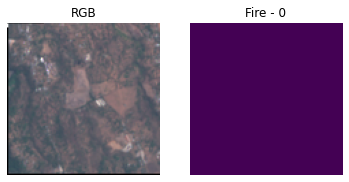

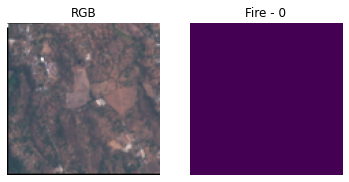

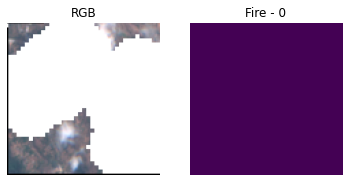

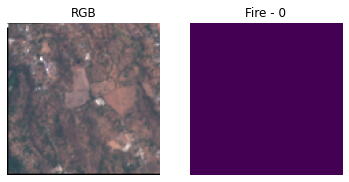

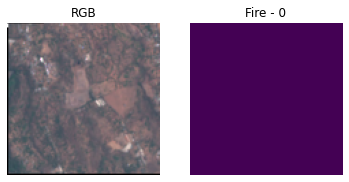

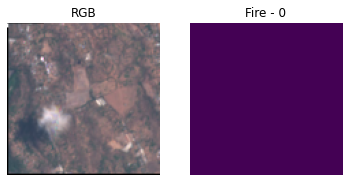

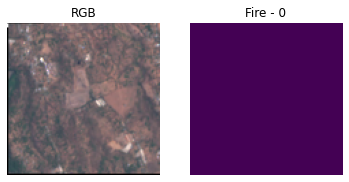

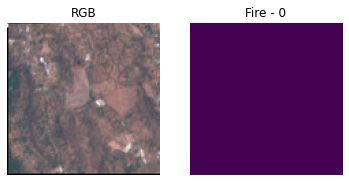

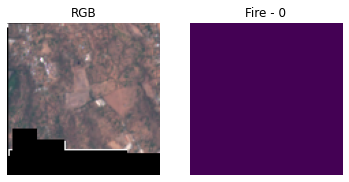

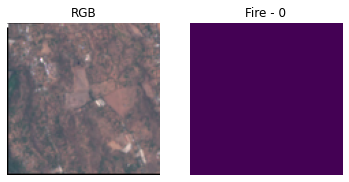

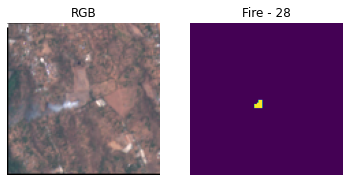

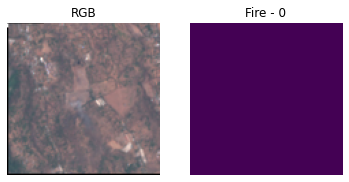

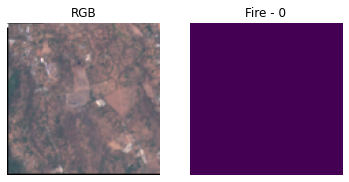

In [46]:
for p in patches:
    plt.subplot(1,2,1)
    plt.title('RGB')
    plt.imshow(np.clip(p[:,:,3:0:-1] / 3000, 0, 1))
    plt.axis('off')
    plt.subplot(1,2,2)
    fire_pix = fire_detection(p)
    plt.title(f'Fire - {np.sum(fire_pix)}')
    plt.imshow(fire_pix)
    plt.axis('off')
    plt.show()

In [30]:
dl_utils.SENTINEL_BANDS

bands = [
    'coastal-aerosol',0,0
    'blue',1,1
    'green',2,2
    'red',3,3
    'nir',7,4
    'swir1',10,5
    'swir2',11,6
    'cloud-mask'_,7
]

['coastal-aerosol',
 'blue',
 'green',
 'red',
 'red-edge',
 'red-edge-2',
 'red-edge-3',
 'nir',
 'red-edge-4',
 'water-vapor',
 'swir1',
 'swir2']

In [24]:
from scripts import dl_utils

rect_width = 0.01
coords = [115.17015, -8.09141]
start_date = '2019-09-01'
end_date = '2019-11-01'
patches, raster_info = dl_utils.download_patch(dl_utils.rect_from_point(coords, rect_width), start_date, end_date)

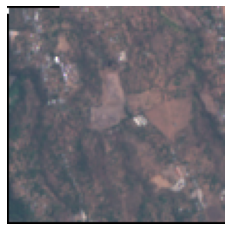

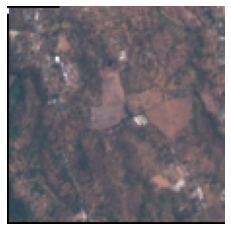

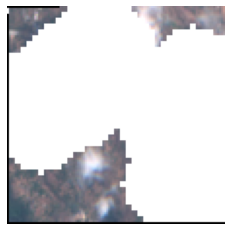

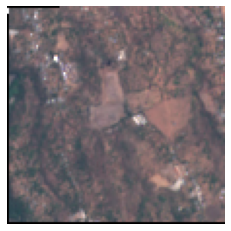

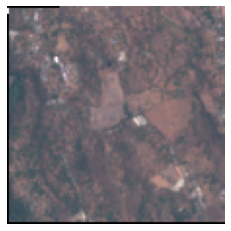

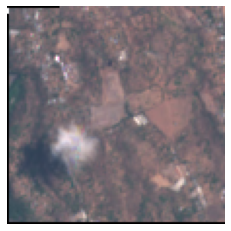

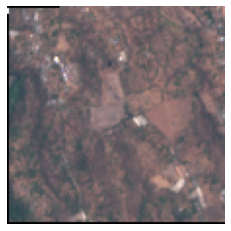

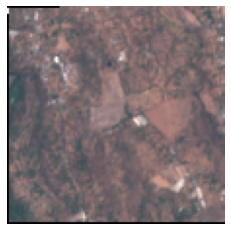

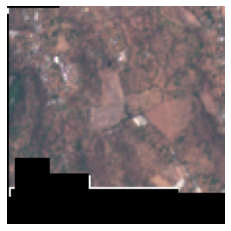

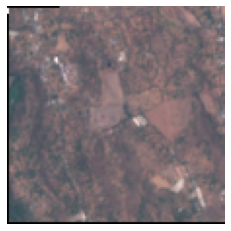

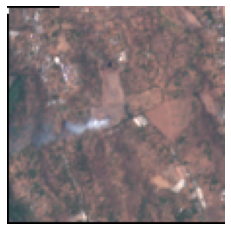

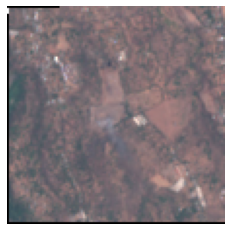

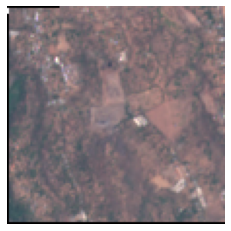

In [29]:
for p in patches:
    plt.imshow(np.clip(p[:,:,3:0:-1] / 3000,0, 1))
    plt.axis('off')
    plt.show()

In [14]:
plot_dir = '../data/fires/figs_by_site'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# find fires in each site
for name in imagery.keys():
    print('\n******************')
    print('Processing {}'.format(name))
    
    s2_scenes, s2_stack = imagery[name]['s2']
    
    s2_fires_scenes = list()
    s2_fires_imgs = list()
    
    for s2_scene, s2_img in zip(s2_scenes, s2_stack):
        fires = fire_detection(s2_img)
        if np.count_nonzero(fires):
            s2_fires_scenes.append(s2_scene)
            s2_fires_imgs.append(s2_img)
            plot_scene(name, s2_scene, s2_img, fires, plot_dir)
            
    if s2_fires_scenes:
        s2_fires_scenes = dl.scenes.SceneCollection(s2_fires_scenes)
    if s2_fires_imgs:
        s2_fires_imgs = np.stack(s2_fires_imgs)
    
    imagery[name]['s2_fires'] = (s2_fires_scenes, s2_fires_imgs)
    
    print('Found {} S2 scenes with fires'.format(len(s2_fires_scenes)))


******************
Processing TPA_Jungut_Batu


/var/folders/qp/7mx_414x647gwz3z5m2rl7780000gn/T/ipykernel_42216/1543643746.py:40: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  fig.savefig(outfile, dpi=300, optimize=True, bbox_inches='tight')


Found 6 S2 scenes with fires

******************
Processing TPA_Biaung
Found 2 S2 scenes with fires

******************
Processing TPA_Sente
Found 0 S2 scenes with fires

******************
Processing TPA_Regional_Bangli
Found 1 S2 scenes with fires

******************
Processing TPA_Peh
Found 0 S2 scenes with fires

******************
Processing TPA_Temesi
Found 47 S2 scenes with fires

******************
Processing TPA_Bengkala
Found 6 S2 scenes with fires

******************
Processing TPA_Bebandem
Found 0 S2 scenes with fires

******************
Processing TPA_Mandung
Found 3 S2 scenes with fires

******************
Processing TPA_Regional_Suwung
Found 85 S2 scenes with fires


### Create a max fire composite for each site

In [15]:
def plot_fires_img(img, name, plot_dir):
    '''
    plot max fires image
    '''
    
    fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300)
    
    ir_img = np.stack([img[6, :, :], img[5, :, :], img[4, :, :]], axis=0)
    ir_img = np.transpose(ir_img, axes=(1, 2, 0))
    ir_img = rescale_img(ir_img, vmin=0.3, vmax=0.7) # custom scaling for viz
    
    name_str = name.replace('_', ' ')
    ax.set_title('{}\nMax Fires Infrared'.format(name_str), fontsize=5)
    ax.imshow(ir_img)
    ax.axis('off')
    
    #plt.show()
    
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
    fname = name + '.jpg'
    outfile = os.path.join(plot_dir, fname)
    
    fig.savefig(outfile, dpi=300, optimize=True, bbox_inches='tight')
    
    plt.close(fig)

In [16]:
# build image collection
ic = wf.ImageCollection.from_id(s2_id)

# filter clouds
ic = ic.filter(lambda img: img.properties['cloud_fraction'] < 0.3)

# mask clouds
cloud = ic.unpack_bands('cloud-mask')
ic = ic.mask(cloud == 1)

In [17]:
# select bands
s2 = ic.pick_bands(bands)
nir, swir2 = ic.unpack_bands(['nir', 'swir2'])

# argmax composite for swir2/nir
comp = s2.sortby_composite(swir2/nir, 'argmax')

In [18]:
tif_dir = '../data/max_fires_tifs'
if not os.path.exists(tif_dir):
    os.makedirs(tif_dir) 

for name in imagery.keys():
    ctx = wf.GeoContext.from_scenes(imagery[name]['ctx'])
    
    # grab ndarray for plotting
    res = comp.compute(ctx)
    fires_img = res.ndarray
    imagery[name]['fire'] = fires_img
    
    # also write to TIF - result should be cached
    fname = os.path.join(tif_dir, name + '.tif')
    comp.compute(ctx, destination='download', format='geotiff', file=fname)
    print('Wrote {}'.format(fname))


Job ID: 544ef74dc747f0eae99afd49ed6eff44f153700d01ae287e
[######] | Steps: 6456/6456 | Stage: SUCCEEDED                                

/Users/ckruse/miniforge3/envs/m1-plastics/lib/python3.9/site-packages/descarteslabs/workflows/models/job.py:368: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  return handler(self)



Job ID: 171a0b97dc932b10aa0fab0b66cc5f07af72c7d26e176516
[######] | Steps: 1/1 | Stage: SUCCEEDED                                      Wrote ../data/max_fires_tifs/TPA_Jungut_Batu.tif

Job ID: 66afdb793a92d1a666b065394a5d2d614661dff583e53bd2
[######] | Steps: 6456/6456 | Stage: SUCCEEDED                                
Job ID: 33e085e07b0b17b2f42376a6fae2152be8f7ade916dd23a4
[######] | Steps: 6098/6098 | Stage: SUCCEEDED                                Wrote ../data/max_fires_tifs/TPA_Biaung.tif

Job ID: 6a1327da5926f110c0b726c628eb2a4605317002823168b3
[######] | Steps: 6518/6518 | Stage: SUCCEEDED                                
Job ID: b2c954dc34affa7e85e043ea10c0cd27490ddc56bb41ef9c
[######] | Steps: 1/1 | Stage: SUCCEEDED                                      Wrote ../data/max_fires_tifs/TPA_Sente.tif

Job ID: 6c7da44f18624a0280a76d5d771bd98a51bae6fb8ad61c4a
[######] | Steps: 6676/6676 | Stage: SUCCEEDED                                
Job ID: 4ec757cc594da8d5bba6d7a7bea67f7d4957393

In [19]:
plot_dir = '../data/max_fires_figs'

for name in imagery.keys():
    plot_fires_img(imagery[name]['fire'], name, plot_dir)

/var/folders/qp/7mx_414x647gwz3z5m2rl7780000gn/T/ipykernel_42216/4152594568.py:25: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  fig.savefig(outfile, dpi=300, optimize=True, bbox_inches='tight')
